In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Applied Machine Learning/BERT implementation /bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<Axes: xlabel='category'>

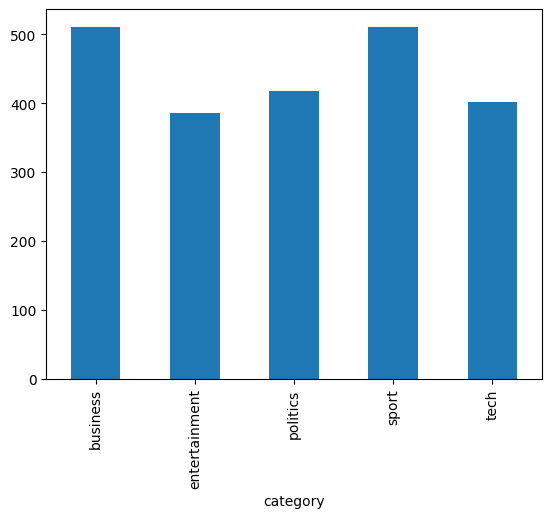

In [4]:
df.groupby('category').size().plot.bar()

In [5]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 94.8 MB/s eta 0:00:00


we need to transform our text into the format that BERT expects by adding [CLS] and [SEP] tokens. We can do this easily with BertTokenizer class from Hugging Face.

In [6]:
from transformers import BertTokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
example_text = 'I am learning to build a BERT transformer model using python for classification.'

bert_input = tokenizer(example_text,padding='max_length', max_length = 20, 
                       truncation=True, return_tensors="pt")

bert_input

{'input_ids': tensor([[  101,   146,  1821,  3776,  1106,  3076,   170,   139,  9637,  1942,
         11303,  1200,  2235,  1606,   185, 25669,  8613,  1111,  5393,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1821,  3776,  1106,  3076,   170,   139,  9637,  1942,
         11303,  1200,  2235,  1606,   185, 25669,  8613,  1111,  5393,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


Padding : To pad each sequence to the maximum length that you specify.

max_length : The maximum length of each sequence. In this example we use 10, but for our actual dataset we will use 512, which is the maximum length of a sequence allowed for BERT.

Truncation : If True, then the tokens in each sequence that exceed the maximum length will be truncated.

return_tensors : The type of tensors that will be returned. Since we’re using Pytorch, then we use pt. If you use Tensorflow, then you need to use tf .

In [10]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I am learning to build a BERT transformer model using python for classification [SEP]


The second row is token_type_ids , which is a binary mask that identifies in which sequence a token belongs. If we only have a single sequence, then all of the token type ids will be 0

The third row is attention_mask , which is a binary mask that identifies whether a token is a real word or just padding. If the token contains [CLS], [SEP], or any real word, then the mask would be 1. Meanwhile, if the token is just padding or [PAD], then the mask would be 0.

If you have datasets from different languages, you might want to use bert-base-multilingual-cased

In [11]:
import torch
import numpy as np
from transformers import BertTokenizer

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

In [13]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [14]:
np.random.seed(112)

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [15]:
from torch import nn
from transformers import BertModel

In [16]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

The first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.

The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier

In [17]:
from torch.optim import Adam
import tqdm

In [18]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [03:14<00:00,  4.58it/s]


Epochs: 1 | Train Loss:  0.772                 | Train Accuracy:  0.318                 | Val Loss:  0.684                 | Val Accuracy:  0.405


100%|██████████| 890/890 [03:14<00:00,  4.57it/s]


Epochs: 2 | Train Loss:  0.629                 | Train Accuracy:  0.485                 | Val Loss:  0.535                 | Val Accuracy:  0.568


100%|██████████| 890/890 [03:16<00:00,  4.54it/s]


Epochs: 3 | Train Loss:  0.412                 | Train Accuracy:  0.696                 | Val Loss:  0.312                 | Val Accuracy:  0.775


100%|██████████| 890/890 [03:16<00:00,  4.54it/s]


Epochs: 4 | Train Loss:  0.240                 | Train Accuracy:  0.822                 | Val Loss:  0.217                 | Val Accuracy:  0.838


100%|██████████| 890/890 [03:16<00:00,  4.53it/s]


Epochs: 5 | Train Loss:  0.124                 | Train Accuracy:  0.951                 | Val Loss:  0.079                 | Val Accuracy:  0.986


In [19]:
 def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.987
